In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Python standard library
import os
from os.path import join
import argparse
import json
import random
import time
from functools import partial

# Data science & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning
import torch
import torch as th
import torch.nn.functional as F
from torchvision.utils import make_grid
import einops

# Progress bars & configuration
from tqdm.auto import tqdm, trange
from easydict import EasyDict as edict

# Commented imports
# import yaml
# from PIL import Image

In [3]:
import sys
sys.path.append("/n/home12/binxuwang/Github/twisted_diffusion_sampler")
sys.path.append("/n/home12/binxuwang/Github/twisted_diffusion_sampler/image_exp")
from smc_utils.feynman_kac_pf import smc_FK 
from image_diffusion.operators import get_operator, ConditioningMethod
# from smc_utils.smc_utils import compute_ess_from_log_w
# from image_diffusion.image_util import get_dataloader, gen_mask, toU8, imwrite 
# from image_diffusion import dist_util
from image_diffusion.script_util import (
    create_gaussian_diffusion, 
    # NUM_CLASSES,
    # classifier_defaults,
    # create_classifier,
    # select_args,
    # create_model_and_diffusion, 
    # model_and_diffusion_defaults, 
    # sampler_defaults, 
    # load_classifier, 
)  # noqa: E402

In [46]:
import sys
# sys.path.append("/n/home12/binxuwang/Github/DiT")
# sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/SiT")
# from diffusion import create_diffusion
# from models import DiT
from models import SiT_models, SiT
from transport import create_transport, Sampler
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch, compute_rule_statistics

In [5]:
# original configs
# sampler_config = edict({'name': 'tds', 'num_particles': 9, 'resample_strategy': 'systematic', 'ess_threshold': 1.0, 't_truncate_percent': 0, 'batch_p': 9})

# task_config = edict({'name': 'inpainting', 'operator': 'inpainting', 'mask': 'half', 'dataset_path': 'datasets/mnist_test', 
#                      'image_size': 28, 'rgb': False, 'classifier_path': './models/resnet.pth.tar', 
#                      'classifier_guidance_scale': 1.0, 'pred_xstart_var_type': 6.0, 'tausq': 0.12})

# diffusion_config = {'learn_sigma': True, 'noise_schedule': 'linear', 'timestep_respacing': '100', 'sampler': 'tds',
#              'use_kl': False, 'predict_xstart': False, 'rescale_timesteps': False, 'rescale_learned_sigmas': False, }

# model_cfg = {'image_size': 28, 'num_channels': 64, 'num_res_blocks': 3, 'num_heads': 4, 
#              'num_heads_upsample': -1, 'num_head_channels': -1, 'attention_resolutions': '28,14,7', 'channel_mult': '', 'dropout': 0, 
#              'class_cond': False, 'use_checkpoint': False, 'use_scale_shift_norm': True, 'resblock_updown': True, 'use_fp16': False, 
#              'use_new_attention_order': False, 'rgb': False, "diffusion_steps": 1000, **diffusion_config}

# model_path = '/n/home12/binxuwang/Github/twisted_diffusion_sampler/image_exp/models/model060000.pt'

debug_plot = False
debug_statistics = False
debug_info = {}
t_truncate_percent = 0
device = 'cuda'

### SiT model 

In [6]:
SiT_configs = {
    "SiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "SiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    "SiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "SiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    "SiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "SiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    "SiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "SiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
}

In [7]:
class_dropout_prob = 1.0
num_classes = 0
model_cfg = SiT_configs["SiT_S_1"]
model_SiT = SiT(
        input_size=9,
        in_channels=3,
        num_classes=num_classes,
        class_dropout_prob=class_dropout_prob,
        learn_sigma=True,
        **model_cfg,
    )

In [8]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
expname = r"014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_SiT.load_state_dict(state_dict['ema']) # "model"
model_SiT.to(device).eval();

In [9]:
config = edict(json.load(open(join(expdir, "args.json"), "r")))
transport = create_transport(
    config.path_type, #"Linear",
    config.prediction, #"velocity", 
    config.loss_weight, #None, 
    config.train_eps, #None,
    config.sample_eps, #None,
)  # default: velocity; 
transport_sampler = Sampler(transport)

In [10]:
!basename -a {exproot}/*

004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None
006-SiT_S_1-stream0_016M_all-Linear-velocity-None
007-SiT_S_1-stream0_16M_all-Linear-velocity-None
008-SiT_S_1-stream1_6M_all-Linear-velocity-None
009-SiT_S_1-stream16M_all-Linear-velocity-None
010-SiT_S_1-stream16M_all-Linear-velocity-None
011-SiT_B_1-stream0_16M_all-Linear-velocity-None
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None
012-SiT_B_1-stream0_016M_all-Linear-velocity-None
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None
013-SiT_B_1-stream16M_all-Linear-velocity-None
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None
014-SiT_B_1-stream1_6M_all-Linear-velocity-None
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None
016-SiT_B_1-stream16M_heldout0-Linear-velocity-None
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None
018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None
019-SiT_B_1-stream16M_all-Linear-ve

In [11]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]

In [12]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = th.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to("cuda")
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to("cuda")
train_sample_img.shape

torch.Size([40, 4000, 3, 9, 9])

In [18]:
batch_size = 2048
zs = th.randn(batch_size, 3, 9, 9).to(device)
ys = torch.zeros((batch_size,), device=device, dtype=torch.int)    
sample_model_kwargs = dict(y=ys)
model_fn = model_SiT.forward
sample_fn = transport_sampler.sample_ode() # default to ode sampling
with th.no_grad():
    samples = sample_fn(zs, model_fn, **sample_model_kwargs)[-1] # takes 75 sec, pretty slow...
samples = ((samples.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

C3: 1425/2048 (0.70), C3 + C2: 1722/2048 (0.84), AnyValid: 5199/6144 (0.85)


In [25]:
# https://github.com/willisma/SiT/blob/cd0ba2ae60b9e929496dd81a7068af340031da3e/transport/transport.py#L226C14-L226C19
transport.get_score()

<function transport.transport.Transport.get_score.<locals>.<lambda>(x, t, model, **kwargs)>

In [23]:
transport_sampler.score()

<function transport.transport.Transport.get_score.<locals>.<lambda>(x, t, model, **kwargs)>

In [14]:
# diffusion_train = create_diffusion(timestep_respacing="")
# diffusion_eval = create_diffusion(timestep_respacing="ddim100")  # default: ddim100
# y = th.zeros(1024, dtype=th.int, device="cuda")
# model_kwargs = dict(y=y)
# with th.no_grad():
#     samples = diffusion_eval.ddim_sample_loop(model_DiT, shape=(1024, 3, 9, 9), clip_denoised=False, device="cuda", 
#                                               model_kwargs=model_kwargs, progress=True)
# samples = ((samples.detach() * dataset_Xstd) + dataset_Xmean).cpu()
# r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)
# C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

C3: 612/1024 (0.60), C3 + C2: 753/1024 (0.74), AnyValid: 2340/3072 (0.76)


### Comparing two diffusion sampler

In [15]:
diffusion_config = {'learn_sigma': True, 'noise_schedule': 'linear', 'timestep_respacing': '100', 'sampler': 'tds',
             'use_kl': False, 'predict_xstart': False, 'rescale_timesteps': False, 'rescale_learned_sigmas': False, }
image_shape = (1, 28, 28)
diffusion = create_gaussian_diffusion(
    **diffusion_config, 
    steps=1000, #model_cfg["diffusion_steps"], # 1000
    image_shape=image_shape, 
)

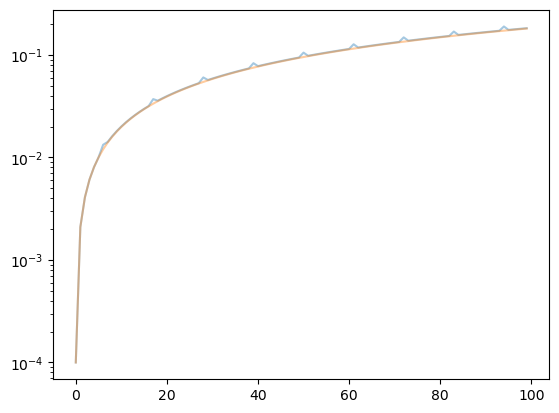

In [16]:
plt.plot(diffusion.betas, alpha=0.4)
plt.plot(diffusion_eval.betas, alpha=0.4)
# y axis log
plt.yscale("log")

In [20]:
dir(diffusion_eval)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_predict_eps_from_xstart',
 '_predict_xstart_from_eps',
 '_prior_bpd',
 '_scale_timesteps',
 '_vb_terms_bpd',
 '_wrap_model',
 'alphas_cumprod',
 'alphas_cumprod_next',
 'alphas_cumprod_prev',
 'betas',
 'calc_bpd_loop',
 'condition_mean',
 'condition_score',
 'ddim_reverse_sample',
 'ddim_sample',
 'ddim_sample_loop',
 'ddim_sample_loop_progressive',
 'log_one_minus_alphas_cumprod',
 'loss_type',
 'model_mean_type',
 'model_var_type',
 'num_timesteps',
 'original_num_steps',
 'p_mean_variance',
 'p_sample',
 'p_sample_loop',
 'p_sample_loop_progressive',
 'posterior_log_variance_clipped',
 'posterior_mean_coef1',
 'post

In [18]:
diffusion.alphas

array([0.9999    , 0.99790636, 0.99591991, 0.99393701, 0.99195767,
       0.98998187, 0.98671027, 0.98584423, 0.9838794 , 0.98191809,
       0.9799603 , 0.97800603, 0.97605527, 0.974108  , 0.97216424,
       0.97022397, 0.96828718, 0.96294629, 0.96423125, 0.96230523,
       0.96038268, 0.95846358, 0.95654794, 0.95463574, 0.95272699,
       0.95082166, 0.94891977, 0.94702131, 0.93970375, 0.94304565,
       0.94115777, 0.93927328, 0.9373922 , 0.9355145 , 0.9336402 ,
       0.93176927, 0.92990171, 0.92803753, 0.92617671, 0.91697234,
       0.92227991, 0.92042949, 0.9185824 , 0.91673866, 0.91489824,
       0.91306115, 0.91122738, 0.90939693, 0.90756978, 0.90574595,
       0.89474192, 0.90192662, 0.90011299, 0.89830264, 0.89649557,
       0.89469178, 0.89289125, 0.89109398, 0.88929997, 0.88750921,
       0.8857217 , 0.87300253, 0.88197846, 0.88020098, 0.87842672,
       0.87665568, 0.87488786, 0.87312324, 0.87136183, 0.86960362,
       0.8678486 , 0.86609676, 0.85174438, 0.86242827, 0.86068

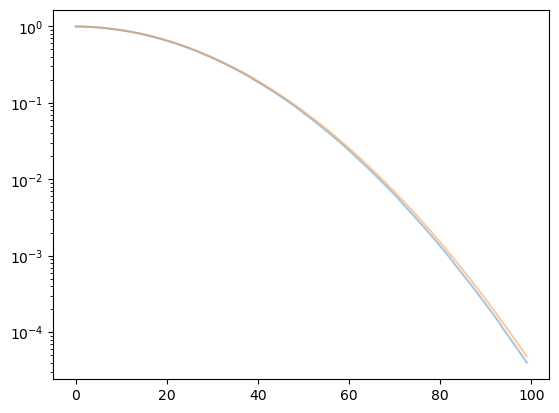

In [17]:
plt.plot(diffusion.alphas_cumprod, alpha=0.4)
plt.plot(diffusion_eval.alphas_cumprod, alpha=0.4)
# y axis log
plt.yscale("log")

### Obtain score from SiT

In [ ]:
transport_sampler.score

<function transport.transport.Transport.get_score.<locals>.<lambda>(x, t, model, **kwargs)>

In [ ]:
model_SiT.forward(th.zeros(2, 3, 9, 9).to(device), \
    th.tensor([0.0, 0.0]).to(device), \
    y=th.zeros(2, dtype=th.int).to(device)).shape

torch.Size([2, 3, 9, 9])

In [ ]:
score_tsr = transport_sampler.score(th.zeros(2, 3, 9, 9).to(device), 
                        th.tensor([0.5, 0.2]).to(device), 
                        model_SiT, y=th.zeros(2, dtype=th.int).to(device))
score_tsr.shape

torch.Size([2, 3, 9, 9])

In [47]:
from transport.path import expand_t_like_x

In [49]:
x = th.zeros(2, 3, 9, 9).to(device)
t = th.tensor([0.5, 0.2]).to(device)
y = th.zeros(2, dtype=th.int).to(device)
noise_tsr = transport_sampler.score(x, t, model_SiT, y=y) * \
                    (- transport_sampler.transport.path_sampler.compute_sigma_t(expand_t_like_x(t, x))[0])
noise_tsr.shape

torch.Size([2, 3, 9, 9])

### Try new samplers from Wu's paper for inpainting single examples

In [30]:
task_config = edict({'name': 'inpainting',
    'operator': 'inpainting',
    'classifier_guidance_scale': 1.0,
    'pred_xstart_var_type': 6.0,
    'tausq': 0.12,
#  'mask': 'half',
#  'dataset_path': 'datasets/mnist_test',
#  'image_size': 28,
#  'rgb': False,
#  'classifier_path': './models/resnet.pth.tar',
 })

In [31]:
sampler_config = edict({'name': 'tds',
    'resample_strategy': 'systematic',
    'ess_threshold': 1.0,
    't_truncate_percent': 0,
#  'num_particles': 9,
#  'batch_p': 9,
 })

In [29]:
# SiT actually don't use learn_sigma, even though it's set to True in the config. out is same shape as x.
# # https://github.com/willisma/SiT/blob/cd0ba2ae60b9e929496dd81a7068af340031da3e/models.py#L245 
# https://github.com/facebookresearch/DiT/blob/ed81ce2229091fd4ecc9a223645f95cf379d582b/diffusion/__init__.py#L10 
diffusion_config = {'learn_sigma': False, # True for DiT, False for SiT 
 'noise_schedule': 'linear',
 'timestep_respacing': '100',
 'sampler': 'tds',
 'use_kl': False,
 'predict_xstart': False,
 'rescale_timesteps': False,
 'rescale_learned_sigmas': False}

In [32]:
image_shape = (3, 9, 9)
diffusion_RPM_tds = create_gaussian_diffusion(
    steps=1000, #model_cfg["diffusion_steps"], # 1000
    image_shape=image_shape, 
    **diffusion_config, 
)
# Create diffusion object
diffusion_RPM_tds.tausq_ = task_config.tausq 
diffusion_RPM_tds.task = task_config.name 
diffusion_RPM_tds.use_mean_pred = True  
diffusion_RPM_tds.t_truncate = int(diffusion_RPM_tds.T * t_truncate_percent)
operator = get_operator(device=device, name=task_config.operator)   
recon_prob_fn = ConditioningMethod(operator=operator).recon_prob

In [33]:
rule_id = 30
sample_id = 10
ref_img = (train_sample_img[rule_id, sample_id].cuda() - dataset_Xmean[0]) / dataset_Xstd[0] 
#th.zeros(3,9,9, device=device)

In [50]:
# def model_fn(x, t, y=None, **kwargs):
    # return score 
    # return transport_sampler.score(x, t, model_SiT, y=y, **kwargs)
# model_DiT(x, t, y, **kwargs) 

def model_fn(x, t, y=None, **kwargs):
    # return eps 
    return transport_sampler.score(x, t, model_SiT, y=y, **kwargs) * \
                    (- transport_sampler.transport.path_sampler.compute_sigma_t(expand_t_like_x(t, x))[0])
# need to rescale, x, t, output. 

tds_batch_size = 9
mask = th.ones((3, 9, 9), device=device, dtype=th.bool)
mask[:,6:,6:] = False
measurement_mask = mask
measurement = operator(ref_img, mask=measurement_mask) # returns a one-dimensional tensor 
assert measurement_mask.shape == ref_img.shape 
recon_prob_fn = partial(recon_prob_fn, measurement=measurement, mask=mask)
# resetting 
diffusion_RPM_tds.mask = mask 
diffusion_RPM_tds.set_measurement(ref_img*measurement_mask) 
diffusion_RPM_tds.recon_prob_fn = recon_prob_fn 
diffusion_RPM_tds.clear_cache() 

M = partial(diffusion_RPM_tds.M, model=model_fn, device=device, 
            pred_xstart_var_type=task_config.pred_xstart_var_type) 
G = partial(diffusion_RPM_tds.G, model=model_fn, 
            debug_plot=debug_plot, debug_statistics=debug_statistics, debug_info=debug_info, 
            pred_xstart_var_type=task_config.pred_xstart_var_type)

y = th.zeros(tds_batch_size, dtype=th.int, device="cuda")
model_kwargs = dict(y=y)
# Sampling 
final_sample, log_w, normalized_w, resample_indices_trace, ess_trace, log_w_trace, xt_trace  = \
    smc_FK(M=M, G=G, 
           resample_strategy=sampler_config.resample_strategy, 
           ess_threshold=sampler_config.ess_threshold, 
           T=diffusion_RPM_tds.T, 
           P=tds_batch_size,  # sampler_config.num_particles
           verbose=True, 
           log_xt_trace=False, 
           extra_vals={"model_kwargs": model_kwargs, 
                       "batch_p": tds_batch_size}) # sampler_config.batch_p

final_sample = ((final_sample.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(final_sample)
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

  0%|          | 0/101 [00:00<?, ?it/s]

C3: 0/9 (0.00), C3 + C2: 9/9 (1.00), AnyValid: 18/27 (0.67)


In [167]:
final_sample = ((final_sample.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(final_sample)
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

C3: 9/9 (1.00), C3 + C2: 9/9 (1.00), AnyValid: 27/27 (1.00)


### Massive production for many samples 

In [25]:
def model_fn(x, t, y=None, **kwargs):
    return model_DiT(x, t, y, **kwargs) 

tds_batch_size = 25
stats_col = []
results_col = []
for rule_id in trange(40):
    for sample_id in trange(25):
        # get ref_img
        ref_img = (train_sample_img[rule_id, sample_id].cuda() - dataset_Xmean[0]) / dataset_Xstd[0]
        # build mask 
        mask = th.ones((3,9,9), device=device, dtype=th.bool)
        mask[:,6:,6:] = False
        measurement_mask = mask
        measurement = operator(ref_img, mask=measurement_mask) # returns a one-dimensional tensor 
        assert measurement_mask.shape == ref_img.shape 
        recon_prob_fn = partial(recon_prob_fn, measurement=measurement, mask=mask)
        # resetting 
        diffusion_RPM_tds.mask = mask 
        diffusion_RPM_tds.set_measurement(ref_img*measurement_mask) 
        diffusion_RPM_tds.recon_prob_fn = recon_prob_fn 
        diffusion_RPM_tds.clear_cache() 

        M = partial(diffusion_RPM_tds.M, model=model_fn, device=device, 
                    pred_xstart_var_type=task_config.pred_xstart_var_type) 
        G = partial(diffusion_RPM_tds.G, model=model_fn, 
                    debug_plot=debug_plot, debug_statistics=debug_statistics, debug_info={}, 
                    pred_xstart_var_type=task_config.pred_xstart_var_type)

        y = th.zeros(tds_batch_size, dtype=th.int, device="cuda")
        model_kwargs = dict(y=y)
        # Sampling 
        final_sample, log_w, normalized_w, resample_indices_trace, ess_trace, log_w_trace, xt_trace  = \
            smc_FK(M=M, G=G, 
                resample_strategy=sampler_config.resample_strategy, 
                ess_threshold=sampler_config.ess_threshold, 
                T=diffusion_RPM_tds.T, 
                P=tds_batch_size,  # sampler_config.num_particles
                verbose=False, 
                log_xt_trace=False, 
                extra_vals={"model_kwargs": model_kwargs, 
                            "batch_p": tds_batch_size}) # sampler_config.batch_p
        final_sample = ((final_sample.detach() * dataset_Xstd) + dataset_Xmean).cpu()
        r3_list, r2_list, rule_col = infer_rule_from_sample_batch(final_sample)
        C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=False)
        inpaintrow_validcount = anyvalid_count - total * 2
        stats_col.append({"rule_id": rule_id, "sample_id": sample_id, "inpaint_acc": C3_count/total, "valid_acc": inpaintrow_validcount/total,})
        results_col.append({"rule_id": rule_id, "sample_id": sample_id, "final_sample": final_sample, "r3_list": r3_list, "r2_list": r2_list, "rule_col": rule_col,
                            "C3_count": C3_count, "C2_count": C2_count, "valid_count": inpaintrow_validcount, "total": total,})
inpaint_stats_df = pd.DataFrame(stats_col)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### Analysis and synopsis

In [46]:
import pickle as pkl
from stats_plot_utils import add_rectangles, saveallforms
from rule_new_utils import rule_table, relation_dict, attribute_dict, rule_table_brief
outdir = join(expdir, "inpainting_results")
os.makedirs(outdir, exist_ok=True)

In [ ]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting"
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)

In [40]:
!echo {outdir}

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results


In [39]:
inpaint_stats_df = pd.DataFrame(stats_col)
inpaint_stats_df.to_csv(join(outdir, "inpaint_stats.csv"), index=False)
inpaint_stats_df.to_pickle(join(outdir, "inpaint_stats.pkl"))
pkl.dump(results_col, open(join(outdir, "inpaint_results.pkl"), "wb"))

In [49]:
results_df = pd.DataFrame(results_col)

In [41]:
inpaint_acc_tab = inpaint_stats_df.groupby("rule_id").agg({"inpaint_acc": "mean", "valid_acc": "mean", }) #"anyvalid_acc": "mean"

In [56]:
heldout_rules
heldout_msk = np.zeros(40, dtype=bool)
heldout_msk[heldout_rules] = 1

print("Overall inpaint accuracy %.3f" % inpaint_acc_tab["inpaint_acc"].mean())
print("- Heldout rule inpaint accuracy %.3f" % inpaint_acc_tab["inpaint_acc"].values[heldout_msk].mean())
print("- Trained rule inpaint accuracy %.3f" % inpaint_acc_tab["inpaint_acc"].values[~heldout_msk].mean())

print("Overall inpaint validity %.3f" % inpaint_acc_tab["valid_acc"].mean())
print("- Heldout rule valid accuracy %.3f" % inpaint_acc_tab["valid_acc"].values[heldout_msk].mean())
print("- Trained rule valid accuracy %.3f" % inpaint_acc_tab["valid_acc"].values[~heldout_msk].mean())

Overall inpaint accuracy 0.470
- Heldout rule inpaint accuracy 0.152
- Trained rule inpaint accuracy 0.515
Overall inpaint validity 0.622
- Heldout rule valid accuracy 0.576
- Trained rule valid accuracy 0.629


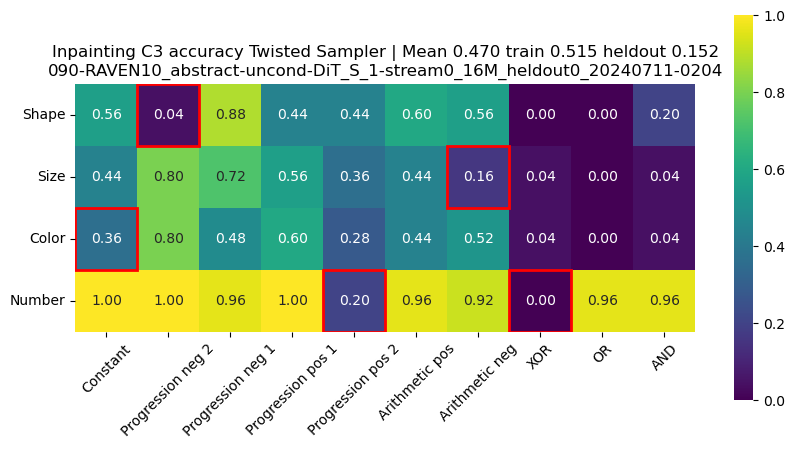

In [74]:
mean_acc = inpaint_acc_tab["inpaint_acc"].mean()
trained_acc = inpaint_acc_tab["inpaint_acc"].values[~heldout_msk].mean()
heldout_acc = inpaint_acc_tab["inpaint_acc"].values[heldout_msk].mean()
plt.figure(figsize=(10, 5))
sns.heatmap(inpaint_acc_tab["inpaint_acc"].values.reshape(4,10), 
            cmap="viridis", annot=True, fmt=".2f")
plt.axis("image")
add_rectangles(heldout_rules)
plt.xticks(np.arange(10)+0.5, [relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
plt.title(f"Inpainting C3 accuracy Twisted Sampler | Mean {mean_acc:.3f} train {trained_acc:.3f} heldout {heldout_acc:.3f}\n{expname}")
saveallforms([outdir,figexpdir], "inpainting_C3_acc_rule_heatmap_pilot")
plt.show()

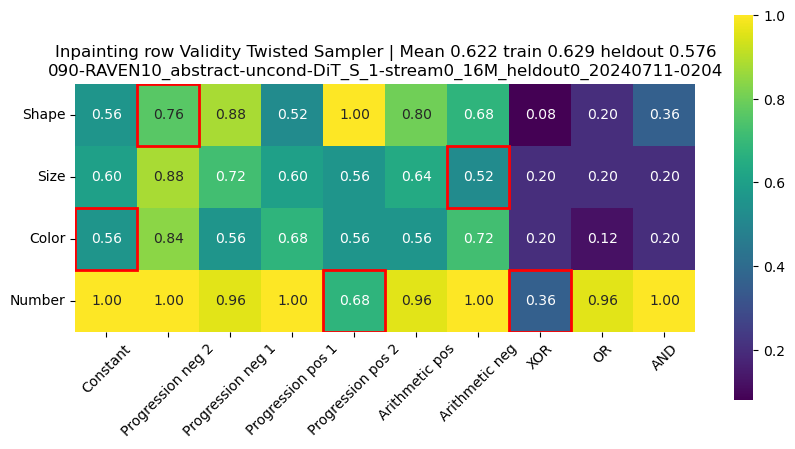

In [75]:
mean_acc = inpaint_acc_tab["valid_acc"].mean()
trained_acc = inpaint_acc_tab["valid_acc"].values[~heldout_msk].mean()
heldout_acc = inpaint_acc_tab["valid_acc"].values[heldout_msk].mean()
plt.figure(figsize=(10, 5))
sns.heatmap(inpaint_acc_tab["valid_acc"].values.reshape(4,10), 
            cmap="viridis", annot=True, fmt=".2f")
plt.axis("image")
add_rectangles(heldout_rules)
plt.xticks(np.arange(10)+0.5, [relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
plt.title(f"Inpainting row Validity Twisted Sampler | Mean {mean_acc:.3f} train {trained_acc:.3f} heldout {heldout_acc:.3f}\n{expname}")
saveallforms([outdir,figexpdir], "inpainting_valid_acc_rule_heatmap_pilot")
plt.show()